<p style="font-family:Roboto; font-size: 28px; color: magenta"> VAE_FashionMnist_TensorFlow</p>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from  keras.layers import Input, Flatten, Dense, Lambda, Reshape, Conv2D, Conv2DTranspose

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Load and Process the Dataset</p>

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

print(X_train.shape, '\t', y_train.shape)
print(X_test.shape, '\t', y_test.shape)

(60000, 28, 28) 	 (60000,)
(10000, 28, 28) 	 (10000,)


In [4]:
'''The pixel values in the data lie between 0 and 255. So, we need to normalise them'''
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [5]:
'''Now, we use the .reshape() fucntion to reshape our data in the format expected by TensorFlow layer i.e.,
 (no of samples, width, height, no of channels)'''
X_train = X_train.reshape((-1,28,28,1))
X_test = X_test.reshape((-1,28,28,1))

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Visualization of Samples</p>

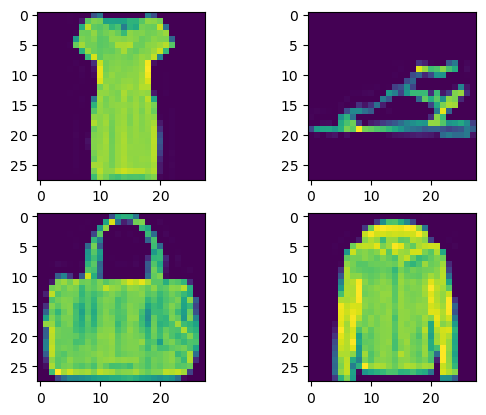

In [6]:
'''We plot a few random observations'''
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[20][:,:,0])

plt.subplot(222)
plt.imshow(X_train[300][:,:,0])

plt.subplot(223)
plt.imshow(X_train[4000][:,:,0])

plt.subplot(224)
plt.imshow(X_train[5000][:,:,0])
plt.show()

<p style="font-family:consolas; font-size: 26px; color: orange; text-decoration-line: overline; "> Model Architecture</p>

In [7]:
'''We now design our VAE model; which involves of an encoder, the latent space and a decoder.
Model implementation wise, the latent space can be considered to be a part of the encoder'''

'We now design our VAE model; which involves of an encoder, the latent space and a decoder.\nModel implementation wise, the latent space can be considered to be a part of the encoder'

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Encoder</p>

In [8]:
enc_input = Input(shape=(28,28,1), name='encoder input')
x = Conv2D(128, 5, padding='same', activation='relu')(enc_input)
x = Conv2D(64, 3, padding='same', strides=2, activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

enc_shape = tf.keras.backend.int_shape(x)

In [9]:
x = Flatten()(x)
x = Dense(32)(x)

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Latent Space</p>

In [10]:
latent_dim = 2 #2D space

z_mean = Dense(latent_dim, name='Z-mean')(x)
z_logvar = Dense(latent_dim, name='Z-logvariance')(x)

In [11]:
'''We need to define a function that takes in the mean and log variance parameters
and return a random sample from the resulting distribution.'''
import keras
def sampling(args):
  mean, logvar = args
  eps = tf.keras.backend.random_normal([latent_dim])

  rnd_sam = mean + tf.keras.backend.exp(logvar/2) * eps
  return rnd_sam

In [12]:
'''By using a Lambda layer, we can thus define our latent space as shown below'''
z = Lambda(sampling, output_shape=(latent_dim,), name='latent-space')([z_mean, z_logvar])
# note that "output_shape" isn't necessary with the TensorFlow backend

In [13]:
encoder = keras.Model(enc_input, z, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │      3,328 │ encoder           │
│                     │ 128)              │            │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │     73,792 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │     36,928 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12544)     │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │    401,440 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Z-mean (Dense)      │ (None, 2)         │         66 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Z-logvariance       │ (None, 2)         │         66 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent-space        │ (None, 2)         │          0 │ Z-mean[0][0],     │
│ (Lambda)            │                   │            │ Z-logvariance[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 552,548 (2.11 MB)

 Trainable params: 552,548 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Decoder</p>

In [14]:
'''Here, we need to take the randomly sampled 2D latent space vector and convert it back
to the original format of the image i.e., 28x28 with a single channel'''
dec_input = Input(shape=(latent_dim,), name='decoder-input')

true_shape = enc_shape[1:]

y = Dense(np.prod(true_shape))(dec_input)
y = Reshape(target_shape=true_shape)(y)
y = Conv2DTranspose(64, 3, padding='same', activation='relu')(y)
y = Conv2DTranspose(64, 3, padding='same', activation='relu')(y)
y = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(y)
y = Conv2DTranspose(128, 5, padding='same', activation='relu')(y)
y = Conv2DTranspose(1, 5, padding='same', activation='relu')(y)

In [15]:
decoder = keras.Model(dec_input, y, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder-input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12544)          │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 128)    │       204,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 1)      │         3,201 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,545 (1.36 MB)

 Trainable params: 356,545 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Connecting all components</p>

In [16]:
enc_output = encoder(enc_input)
dec_output = decoder(enc_output)


vae = keras.Model(enc_input, dec_output, name='VAE')
vae.summary()

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │       552,548 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       356,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 909,093 (3.47 MB)

 Trainable params: 909,093 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

<p style="font-family:consolas; font-size: 26px; color: orange; text-decoration-line: overline; "> Training</p>

In [17]:
'''First, we need to define a custom loss function which trains our model based to improve an error
defined as the sum of reconstruction loss and KL-Divergence loss.'''
def loss_func(z_mean, z_logvar):

    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 100
        reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(z_mean, z_logvar):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + z_logvar - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_logvar), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + z_logvar - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_logvar), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [18]:
'''We can now compile and train'''
opt = keras.optimizers.Adam(learning_rate=0.0001)
vae.compile(optimizer=opt, loss=loss_func(z_mean, z_logvar))

In [19]:
history = vae.fit(X_train, X_train, epochs=20, batch_size=32, validation_data=(X_test, X_test))

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 10.3525 - val_loss: 7.7259
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - loss: 7.6173 - val_loss: 7.4955
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 7.4549 - val_loss: 7.3572
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 7.4032 - val_loss: 7.3126
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 7.3382 - val_loss: 7.2936
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 7.2684 - val_loss: 7.3684
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 7.2485 - val_loss: 7.2274
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 7.1795 - val_loss: 7.1834
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 7.1849 - val_loss: 7.1622
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - loss: 7.1558 - val_loss: 7.1645
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 7.1463 - val_loss: 7.1230
Epoch 1

In [ ]:
'''
Here, we performed naive hyperparameter tuning and achieved the above results.
Whether the above loss is satisfactory or not depends on how well the model can reconstruct a given sample.
This can only be gauged by visualising a few test observations.
'''

<p style="font-family:consolas; font-size: 26px; color: orange; text-decoration-line: overline; "> Visualization of Test samples</p>

In [ ]:
%time
index = int(input())

y_pred = vae.predict(X_test)

plt.figure(1)
plt.subplot(221)
plt.imshow(X_test[index].reshape(28,28))

plt.subplot(222)
plt.imshow(y_pred[index].reshape(28,28))

plt.subplot(223)
plt.imshow(X_test[index*5].reshape(28,28))

plt.subplot(224)
plt.imshow(y_pred[index*5].reshape(28,28))
plt.show()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.63 µs


<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Downloading our models</p>

In [21]:
keras.models.save_model(encoder, 'fm_encoder.h5')
keras.models.save_model(decoder, 'fm_decoder.h5')
keras.models.save_model(vae, 'fm_vae.h5')

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Exploring our Latent Space</p>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


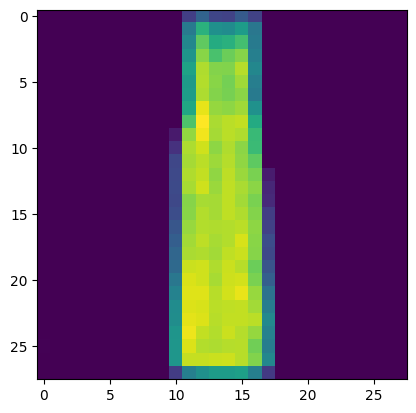

In [22]:
'''
The main application of a VAE is to obtain a low dimensional latent space for our data.
Theoritically, every vector in this space is a reduced version of some sample in the original feature space.
Exploring the latent space may therefore allow us to find weird,
unique and interesting images that may be similar to training samples.
The resulting visualization would look cooler with human face datasets, cat image datasets etc,
but our plots get the point across.
'''
sample_vector = np.array([[3,7]])
decoded_example = decoder.predict(sample_vector)
plt.imshow(decoded_example.reshape(28,28))